This is a version of object detection that goes through the thought process more in depth.

##### Step 1. Loading the Input image/s

In [68]:
# import dependencies 
import os 
os.environ ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# SAM/OpenCLIP dependencies
import torch
import torchvision
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import Image as Image_Open
from PIL import Image
import open_clip

# COCO dependencies
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

Load COCO and initialize the labels from Val 2017 annotations

In [2]:
# Loading COCO
dataDir='..'
dataType='val2017'
annFile='{}/coco/annotations/instances_{}.json'.format(dataDir,dataType)

# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=1.10s)
creating index...
index created!


In [25]:
# display COCO categories and store them into array 'labels'. Tokenize the labels using OpenCLIP
cats = coco.loadCats(coco.getCatIds())
labels = [cat['name'] for cat in cats]
print(labels)

# Tokenize the labels
labels_tokenized = open_clip.tokenize(["This is " + desc for desc in labels])

['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


Load input image using COCO

In [24]:
# randomly sample an image from COCO Val split 2017
# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['person','dog','skateboard']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [324158])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

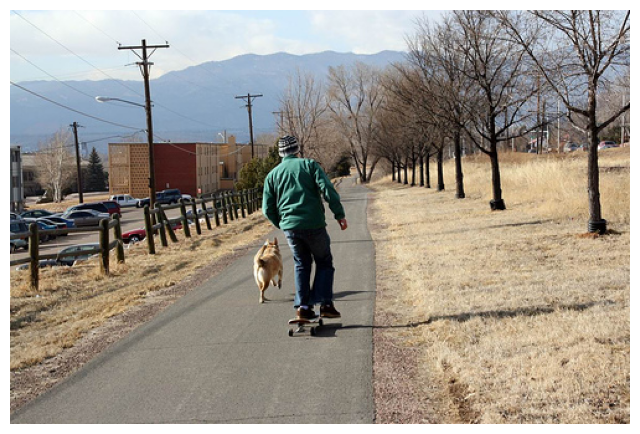

In [120]:
# load and display image
image = io.imread(img['coco_url']) 

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image) 
plt.imshow(tempImg)
plt.axis('off')
plt.show() 

Load input image locally

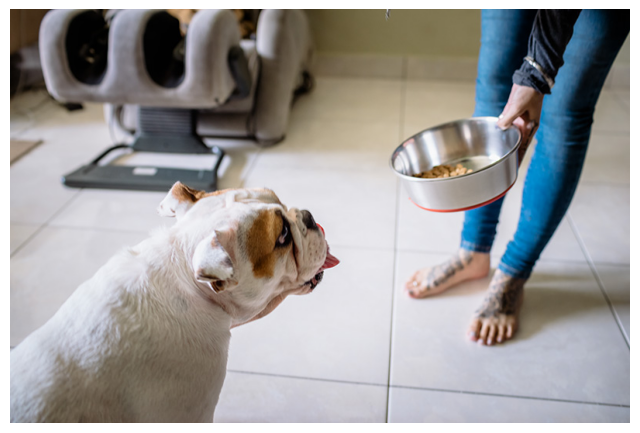

In [131]:
# load and display image
image = cv2.imread('images/dog.jpg') 
# convert image to be readable by SAM
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# tempImg to be cropped for some functions
tempImg = Image.fromarray(image)
plt.imshow(tempImg)
plt.axis('off')
plt.show() 

##### Step 2. Segment Anything Output

In [7]:
# Loading SAM Model
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "../sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Loading SAM Predictor
mask_generator = SamAutomaticMaskGenerator(sam)

In [132]:
# Run automatic mask generation
masks = mask_generator.generate(image)
length_masks = len(masks)

In [28]:
# Loading OpenCLIP
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

##### Step 3. Cropping the image depending on the SAM output (masks)

In [95]:
def get_cropped_image(mask):
    # convert the XYWH bounding box to LURD format
    bbox_xywh = masks[mask]['bbox'] # the SAM model returns the bounding box in xywh format
    bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2], 
    bbox_xywh[1] + bbox_xywh[3]] # convert the bounding box to LURD format
    
    # Crop the image using the bounding box coordinates
    cropped_image = tempImg.crop(bbox_lurd) 
    display_image = cropped_image.convert("RGB")
    cropped_image = transform(display_image).unsqueeze(0)
    
    return cropped_image, display_image

##### Step 4. Getting the output label prediction from openCLIP.

In [117]:
# Run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
def get_label(mask):
    # crop the image AKA get the bounding box
    cropped_image, display_image = get_cropped_image(mask)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        text_features = model.encode_text(labels_tokenized).float()
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)
    
    # return the highest probability label and its percentage
    return labels[top_labels[0][0].item()], top_probs[0][0].item()

    # print("predicted label: ", predicted_label)
    # print("top_labels:\n1. ", labels[top_labels[0][0].item()], ": ", top_probs[0][0].item(),
    #       "\n2. ", labels[top_labels[0][1].item()], ": ", top_probs[0][1].item())
    
    # plt.axis('off')
    # plt.imshow(display_image)
    # plt.show()

In [127]:
print(get_label(2))

('airplane', 0.318730890750885)


In [133]:
# create a dictionary of labels and the corresponding probabilities
label_dict = {}
for mask in range(length_masks):
    label, probability = get_label(mask)
    if label not in label_dict:
        label_dict[label] = []
    label_dict[label].append((label, probability))
    print("mask #", mask, "label: ", label, "probability: ", probability)

mask # 0 label:  dog probability:  0.9790651798248291
mask # 1 label:  dog probability:  0.9092226028442383
mask # 2 label:  bowl probability:  0.8839098811149597
mask # 3 label:  bowl probability:  0.9960882663726807
mask # 4 label:  cat probability:  0.17559267580509186
mask # 5 label:  baseball bat probability:  0.3491961658000946
mask # 6 label:  airplane probability:  0.38057491183280945
mask # 7 label:  person probability:  0.46899256110191345
mask # 8 label:  cup probability:  0.20401033759117126
mask # 9 label:  baseball bat probability:  0.3022913932800293
mask # 10 label:  bowl probability:  0.9703684449195862
mask # 11 label:  person probability:  0.18839600682258606
mask # 12 label:  person probability:  0.36188820004463196
mask # 13 label:  person probability:  0.10713031888008118
mask # 14 label:  baseball bat probability:  0.1942378431558609
mask # 15 label:  baseball bat probability:  0.10104429721832275
mask # 16 label:  dog probability:  0.9839460253715515
mask # 17 l

In [101]:
print(label_dict)

{'airplane': [('airplane', 0.318730890750885), ('airplane', 0.38339364528656006)], 'skateboard': [('skateboard', 0.9451492428779602), ('skateboard', 0.9568743109703064)], 'dog': [('dog', 0.3698880076408386)], 'kite': [('kite', 0.5068699717521667), ('kite', 0.3222072720527649)], 'refrigerator': [('refrigerator', 0.22440074384212494), ('refrigerator', 0.20879098773002625), ('refrigerator', 0.2520822584629059), ('refrigerator', 0.10171206295490265)], 'person': [('person', 0.8619441986083984), ('person', 0.6104921698570251), ('person', 0.5858160257339478), ('person', 0.11098811775445938), ('person', 0.11381707340478897), ('person', 0.2292160540819168), ('person', 0.44621556997299194), ('person', 0.1701553463935852), ('person', 0.3344302475452423), ('person', 0.12377114593982697), ('person', 0.12463688850402832), ('person', 0.15708529949188232), ('person', 0.33448079228401184), ('person', 0.11733663082122803), ('person', 0.2486366331577301)], 'stop sign': [('stop sign', 0.6565710306167603),

In [102]:
for key in label_dict:
    label_dict[key].sort(key=lambda x: x[1], reverse=True)

In [103]:
print(label_dict)

{'airplane': [('airplane', 0.38339364528656006), ('airplane', 0.318730890750885)], 'skateboard': [('skateboard', 0.9568743109703064), ('skateboard', 0.9451492428779602)], 'dog': [('dog', 0.3698880076408386)], 'kite': [('kite', 0.5068699717521667), ('kite', 0.3222072720527649)], 'refrigerator': [('refrigerator', 0.2520822584629059), ('refrigerator', 0.22440074384212494), ('refrigerator', 0.20879098773002625), ('refrigerator', 0.10171206295490265)], 'person': [('person', 0.8619441986083984), ('person', 0.6104921698570251), ('person', 0.5858160257339478), ('person', 0.44621556997299194), ('person', 0.33448079228401184), ('person', 0.3344302475452423), ('person', 0.2486366331577301), ('person', 0.2292160540819168), ('person', 0.1701553463935852), ('person', 0.15708529949188232), ('person', 0.12463688850402832), ('person', 0.12377114593982697), ('person', 0.11733663082122803), ('person', 0.11381707340478897), ('person', 0.11098811775445938)], 'stop sign': [('stop sign', 0.6565710306167603),

##### Step 5. If label is in COCO: compare prediction with ground truth score using mAP, Else: ignore

In [134]:
# import dependencies for COCO evaluation
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [136]:
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
prefix = 'person_keypoints' if annType=='keypoints' else 'instances'
print('Running demo for *%s* results.'%(annType))

Running demo for *bbox* results.


In [139]:
#initialize COCO ground truth api
dataDir='../'
dataType='val2017'
prefix = 'instances'
annFile = '%s/coco/annotations/%s_%s.json'%(dataDir,prefix,dataType)
cocoGt=COCO(annFile)

loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


In [140]:
#initialize COCO detections api
resFile='%s/results/%s_%s_fake%s100_results.json'
resFile = resFile%(dataDir, prefix, dataType, annType)
cocoDt=cocoGt.loadRes(resFile)

Loading and preparing results...


FileNotFoundError: [Errno 2] No such file or directory: '..//results/instances_val2017_fakebbox100_results.json'

In [ ]:
# Run through all the masks and then crop image to ask OpenClip "This is a photo of what?"
def get_label(mask):
    # crop the image AKA get the bounding box
    cropped_image, display_image = get_cropped_image(mask)
    
    # ask OpenClip "This is a photo of what?"
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(cropped_image).float()
        text_features = model.encode_text(labels_tokenized).float()
    
    # Normalize the features and calculate the dot product of each pair.
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    
    # Get the predicted label
    predicted_label_index = similarity.argmax()
    predicted_label = labels[predicted_label_index]
    
    # get the top 2 probabilities and labels
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    top_probs, top_labels = text_probs.cpu().topk(2, dim=-1)
    
    # return the highest probability label and its percentage
    return labels[top_labels[0][0].item()], top_probs[0][0].item()

    # print("predicted label: ", predicted_label)
    # print("top_labels:\n1. ", labels[top_labels[0][0].item()], ": ", top_probs[0][0].item(),
    #       "\n2. ", labels[top_labels[0][1].item()], ": ", top_probs[0][1].item())
    
    # plt.axis('off')
    # plt.imshow(display_image)
    # plt.show()

scratchpaper area.

In [128]:
bbox_xywh = masks[0]['bbox']
print(bbox_xywh)

# Convert the bounding box to LURD format
bbox_lurd = [bbox_xywh[0], bbox_xywh[1], bbox_xywh[0] + bbox_xywh[2],bbox_xywh[1] + bbox_xywh[3]]
print(bbox_lurd)

[0, 0, 352, 68]
[0, 0, 352, 68]


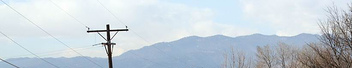

In [129]:
cropped_image = im.crop(bbox_lurd) # Crop the image using the bounding box coordinates
cropped_image.convert("RGB")

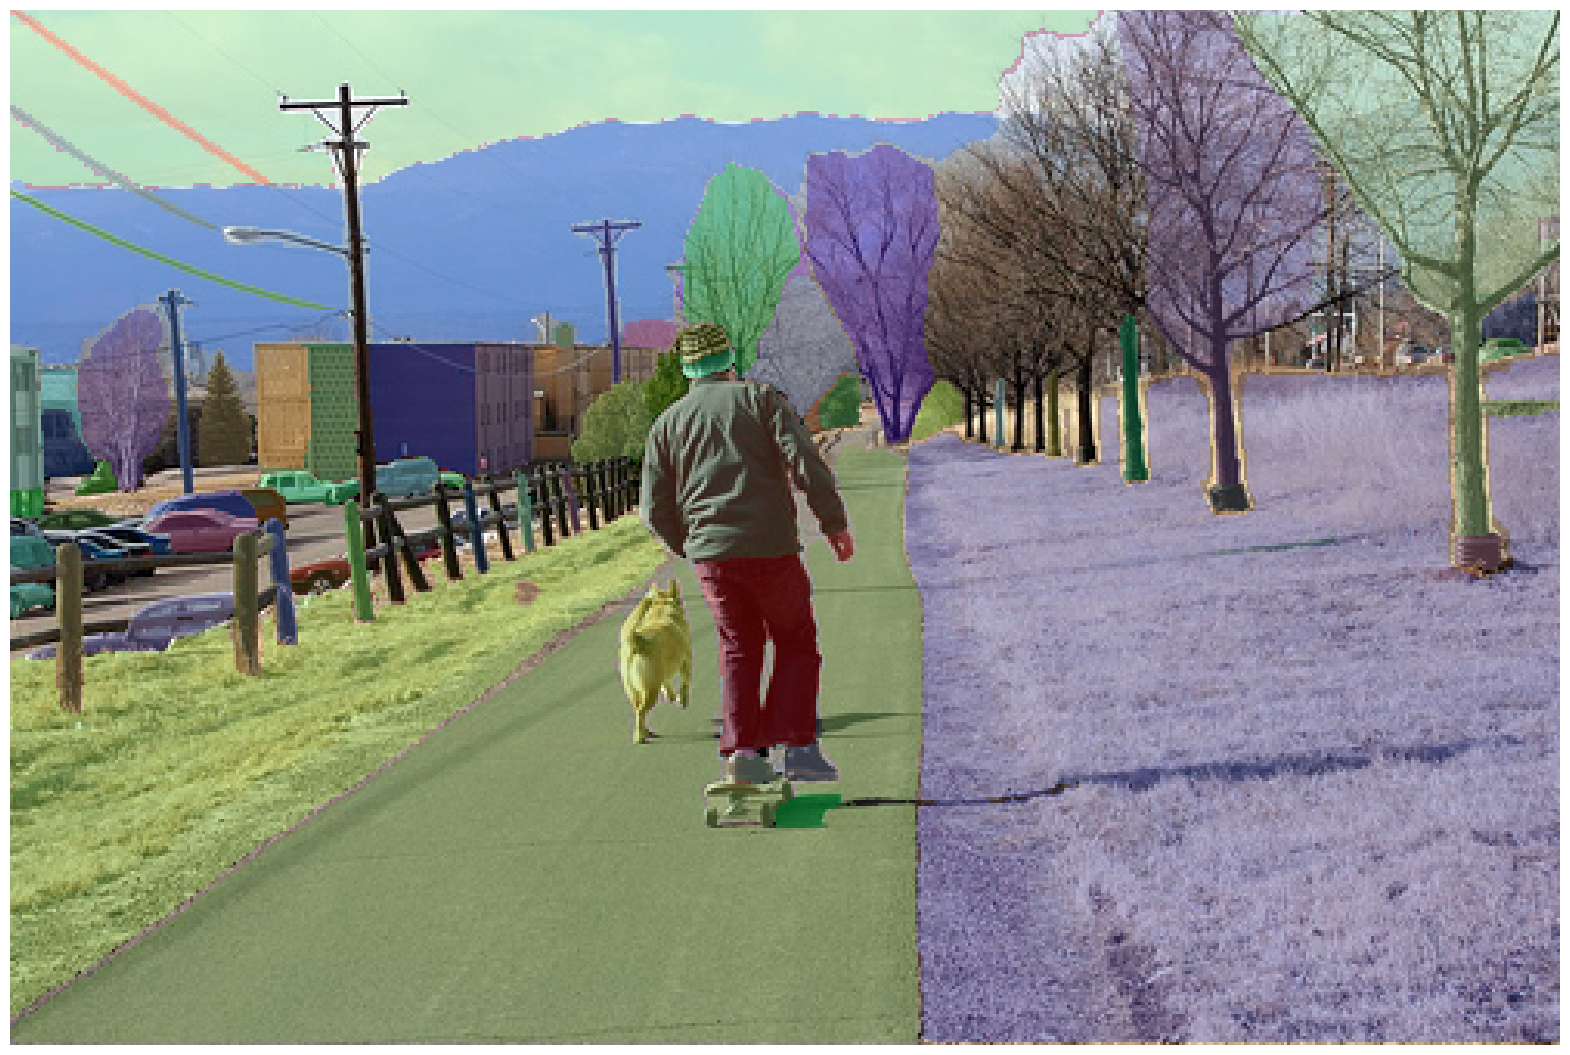

In [59]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 